**목차** 

[1.소개](#소개)  
[2.패키지 로딩](#패키지-로딩)  
[3.데이터 로딩](#데이터-로딩)  
[4.데이터 인사이트](#데이터-인사이트)  
[5.Metadata](#Metadata)  
[6.Descriptive statistics](#Descriptive-statistics)  
[7.Imbalanced class들 다루기](#Imbalanced-class들-다루기)  


# 소개

이 노트북은 Porto Seguro 대회에 대한 데이터의 insight를 얻는 것이 목적이다.  
그 외에 데이터 모델링에 대한 몇가지 팁과 재주를 얻을 수 있다. 이 노트북은 아래와 같은 세션으로 구성되어 있다.  

1. 데이터 시각화(Defining the metadata)
2. metadata 정의(Defining the metadata)
3. 기술적인 통계(Descriptive statistics)
4. ibalanced class들을 다루기(Handling imbalanced classes)
5. 데이터 질 확인(Data quality checks)
6. 탐색적 데이터 시각화(Exploratory data visualization)
7. 기계 학습(Feature engineering)
8. 특징 선택(Feature selection)
9. 데이터 시각화(Feature scaling)

참고 : Porto Seguro는 브라질의 자동차 보험 회사입니다. 본 경진 대회의 목적은 어떤 차주가 내년에 보험 청구를 할 확률을 예측하는 겁니다.

# 패키지 로딩

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer 
#sklearn.preprocessing.Imputer 클래스가 삭제되어 sklearn.impute.SimpleImputer로 대체함
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100) #화면에 보이는 최대 열수를 100으로 설정

# 데이터 로딩

In [31]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [32]:
train[train['ps_car_12'] == -1]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
298018,744626,0,0,1,6,0,1,0,0,1,0,0,0,0,0,0,12,0,1,0,0.4,0.0,0.627495,7,1,0,8,1,11,0,1,2,1,104,3,-1.0,0.686589,0.478539,0.0,0.3,0.7,0.3,3,2,9,4,10,1,6,11,1,0,10,0,0,1,0,0,0


# 데이터 인사이트

아래 글은 이 대회에 대한 데이터 설명의 발췌문임

- 유사한 그룹에 속하는 특성은 특성 이름으로 태그가 붙는다  (e.g., ind, reg, car, calc). -> 각 Feature의 이름을 정확히 알려주지 않음
- 특성 이름들은 각자 접미사를 포함하는데, binary features의 경우 **bin**을, categorical features의 경우 **cat**을 뒤에 붙인다. 
- 위의 지칭이 없는 특성의 경우, continuous or ordinal 이다.
- -1의 값은 NaN 값을 의미한다.
- 대상 열은 해당 policy holder가 클레임을 접수했는지 여부를 나타낸다. -> target은 보험 청구를 함(=1), 안함 (=0) binary feature이다.
------------------------------------------------------------------------------------------------------------------------------------------
- Features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc).
- Feature names include the postfix bin to indicate binary features and cat to indicate categorical features.
- Features without these designations are either continuous or ordinal.
- Values of -1 indicate that the feature was missing from the observation.
- The target columns signifies whether or not a claim was filed for that policy holder.

In [33]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [34]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


위의 자료를 보고 알 수 있는 것
- binary 변수
- categorical 변수는 정수
- 다른 변수들은 정수 or 실수
- -1은 NaN
- target 변수와 id 변수
----------------------------------
We indeed see the following

- binary variables
- categorical variables of which the category values are integers
- other variables with integer or float values
- variables with -1 representing missing values
- the target variable and an ID variable

행과 열의 수 보기

In [35]:
train.shape

(595212, 59)

59개의 열과 595212개의 행. 
중복되는 데이터를 지우기

In [36]:
train.drop_duplicates()
train.shape

(595212, 59)

중복되는 데이터 x

In [37]:
test.shape

(892816, 58)

train에 비해 열이 하나 적지만, 이는 target 열이 빠진 것이기 때문에 정상이다.

각 열의 데이터 분석

이후에 우리는 카테고리 열에 대한 14개의 더미 열을 만들어야한다. bin 열의 경우 이미 binary 값이기 때문에 더미를 만들 필요가 없다.

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

위의 info 정보를 보면, 데이터 자료형이 정수 or 실수 인 것을 볼 수 있다. NaN이 없는 이유는 위에서 언급했듯이 Nan값이 -1로 저장되어있기 때문이다.

# Metadata

데이터 관리를 용이하게 하기 위해서 각 변수에 대한 meta-데이터를 저장해야한다. 이것은 앞으로의 분석을 편하게 만들어 줄 것이다.

구체적으로 아래에 대한 것을 정리할 것이다.
- **role** : input, ID, target
- **level** : nominal, interval, ordinal, binary
- **keep** : True or False
- **dtype** : int, float, str

데이터의 종류 :
http://blog.heartcount.io/dd

In [39]:
data = []
for f in train.columns : 
    #role 정의하기
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
        

    #level 정의
    if 'bin' in f or f == 'target' :
        level = 'binary'
    elif 'cat' in f or f == 'id' :
        level = 'nominal'
    elif train[f].dtype == float :
        level = 'interval'
    #elif로 했을 때, 이유는 모르겠지만 level이 ordinal이 아니라 binary로 들어가서 수정
    #elif train[f].dtype == int :
    else :
        #print(f)
        level = 'ordinal'
    
    #keep을 id를 제외한 모든 변수에서 True로 설정
    keep = True
    if f == 'id' :
        keep = False
    
    #dtype 정의
    dtype = train[f].dtype
    
    # meta 데이터를 저장할 Dic 생성
    f_dict = {
        'varname' : f,
        'role' : role,
        'level' : level,
        'keep' : keep,
        'dtype' : dtype
    }
    data.append(f_dict) #data 리스트에 

meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace = True) #set_index는 다음을 참조 : https://kongdols-room.tistory.com/123

In [40]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


Example to extract all nominal variables that are not dropped

In [41]:
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

level과 role의 변수 비율의 수

In [42]:
pd.DataFrame({'count' : meta.groupby(['role', 'level',])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# Descriptive statistics

DataFrame의 descriptive 방법을 사용할 수 있지만, 말이 안된다.

위에서 meta 데이터를 만들었기 때문에, 우리가 통계적으로 계산하길 원하는 변수를 쉽게 선택할 수 있다. 이를 명확하게 하기 위해서 데이터 유형별로 작업을 진행할 것이다.

## Interval variables (상호변수)

In [43]:
v = meta[ (meta.level == 'interval') & (meta.keep)].index
train[v].describe() #describe()는 다양한 통계량을 요약해주는 굉장히 편리한 메서드

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


min 값이 -1이면, NaN 값이 있는 것

### reg variables

- 오직 ps_reg_03이 NaN 값을 갖음
- 변수들의 범위(최소~최대)가 다르다. 이를 scaling할 수 있지만, 이는 우리가 사용할 classifier에 따라 할지, 안할지가 결정됨

### car variables

- ps_car_12와 ps_car_15는 NaN 값을 갖음
- 6.1.1과 같이 변수의 범위가 다르고, scaling을 적용할 수 있음

### calc variables

- NaN 값 없음
- 최대값이 0.9이기 때문에 이는 일종의 비율인 것 같음
- 세 calc 변수들이 모두 비슷한 분포임

**결과적으로**, interval 변수들의 범위가 작다는 것을 볼 수 있다. 아마 이름을 만드는 과정에서 이미 변환(e.g. log)이 적용된 것 같다

## Ordinal variables

In [44]:
v = meta[ (meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


- 오직 ps_car_11만이 NaN 값을 갖음
- 변수의 범위가 다르고, scaling을 적용할 수 있음

## Binary variables

In [45]:
v = meta[ (meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- 첫 데이터를 보면 3.645% 이다. 이는 매운 **imbalanced**한 값이다.
- target의 평균값을 보면 각 변수의 값이 대부분 0 이라는 것을 알 수 있다.

# Imbalanced class들 다루기

위에서 언급했던 것처럼 target의 값이 대부분 0 이다. 이것은 모델이 굉장한 정확도를 갖게 할 수 있지만, 실제는 부가적인 값을 갖고 있을 수 있다. 이 문제를 해결하기 위한 두 가지 전략이 있다.
 
- target=1로 oversampling 하는 것
- target=1로 undersampling 하는 것

trainining set이 크기 때문에, undersampling 방식을 사용할 것이다.

더 많은 방식이 있으며 MachineLearningMastery.com은 좋은 관점을 줄 것이다. 

undersampling과 oversampling 설명은 링크를 참조 : https://shinminyong.tistory.com/34

In [47]:
desired_apriori = 0.10

# target 값 당 index들 구하기
idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index

# target 값 당 기록의 수 구하기
nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])

# undersampling rate와 결과 레코드 수 계산
undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('undersampling 비율(taget = 0) : {}'.format(undersampling_rate))
print('결과 레코드 수 : {}'.format(undersampled_nb_0))

# 원하는 priori를 얻기 위해 레코드를 랜덤으로 선택
undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# 남아있는 인덱스들을 리스트로 생성
idx_list = list(undersampled_idx) + list(idx_1)

# undersample 데이터 프레임을 반환
train = train.loc[idx_list].reset_index(drop=True)

undersampling 비율(taget = 0) : 0.34043569687437886
결과 레코드 수 : 195246


In [48]:
train[train['ps_car_12'] == -1]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin


# 데이터 질 확인
Data Quality Checks

## NaN 값 확인

NaN 값은 현재 -1로 나와있음

In [49]:
#train.columns

In [50]:
vars_with_missing = []

for f in train.columns :
    missings = train[train[f] == -1][f].count()
    if missings > 0 :
        vars_with_missing.append(f)
        missings_perc = missings/train.shape[0]
        
        print('변수 : {}는 NaN 값을 {}개 갖고 있다. 이는 기록의 {:.2%} 이다.'.format(f,missings,missings_perc))
        
print('총 {}의 변수들이 NaN 값을 갖고 있다.'.format(len(vars_with_missing)))

변수 : ps_ind_02_cat는 NaN 값을 103개 갖고 있다. 이는 기록의 0.05% 이다.
변수 : ps_ind_04_cat는 NaN 값을 51개 갖고 있다. 이는 기록의 0.02% 이다.
변수 : ps_ind_05_cat는 NaN 값을 2256개 갖고 있다. 이는 기록의 1.04% 이다.
변수 : ps_reg_03는 NaN 값을 38580개 갖고 있다. 이는 기록의 17.78% 이다.
변수 : ps_car_01_cat는 NaN 값을 62개 갖고 있다. 이는 기록의 0.03% 이다.
변수 : ps_car_02_cat는 NaN 값을 2개 갖고 있다. 이는 기록의 0.00% 이다.
변수 : ps_car_03_cat는 NaN 값을 148367개 갖고 있다. 이는 기록의 68.39% 이다.
변수 : ps_car_05_cat는 NaN 값을 96026개 갖고 있다. 이는 기록의 44.26% 이다.
변수 : ps_car_07_cat는 NaN 값을 4431개 갖고 있다. 이는 기록의 2.04% 이다.
변수 : ps_car_09_cat는 NaN 값을 230개 갖고 있다. 이는 기록의 0.11% 이다.
변수 : ps_car_11는 NaN 값을 1개 갖고 있다. 이는 기록의 0.00% 이다.
변수 : ps_car_14는 NaN 값을 15726개 갖고 있다. 이는 기록의 7.25% 이다.
총 12의 변수들이 NaN 값을 갖고 있다.


- **ps_car_03_cat와 ps_car_05_cat**는 NaN 값이 높은 비율을 차지하고 있음, 이 변수들을 제거해야한다.
- 다른 카테고리 변수들의 경우, NaN 값을 그냥 내버려둘 수 있다.
- **ps_reg_03**(continuous)는 NaN 값이 18%를 차지하고 있다. 이는 평균값으로 대체할 것이다.
- **ps_car_11**(ordinal)은 단 5개의 NaN 값을 갖고 있다. 이는 최빈값으로 대체할 것이다.
- **ps_car_12**(continuous)은 단 1개의 NaN 값을 갖고 있다. 이는 평균값으로 대체할 것이다. --> undersampling 과정에서 삭제된듯하다.
- **ps_car_14**(continuous)는 NaN 값이 7%를 차지하고 있다. 이는 평균값으로 대체할 것이다.

In [51]:
# NaN값을 너무 많이 포함한 변수들 제거
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
meta.loc[(vars_to_drop), 'keep'] = False # meta 데이터 업데이트

# 최빈값이나 평균값으로 대체하기
mean_imp = SimpleImputer(missing_values = -1, strategy = 'mean') #SimpleImputer에는 axis 매개변수 없음, 기본동작 방식은 클래스의 axis = 0일 때와 같음
mode_imp = SimpleImputer(missing_values = -1, strategy = 'most_frequent')
#SimpleImputer에 대해서는 링크 참조 : https://thebook.io/007022/ch04/01/03-01/

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel() # ravel()은 다차원을 1차원으로 바꾸는 함수 (Numpy)
#train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel() 
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()

## categorical 변수들의 집합의 크기 확인하기

집합은 변수의 여러 값 수를 나타낸다. 이후에 categorical 변수들에서 더미 변수를 만들 것이기 때문에, 구별되는 값이 많은 변수가 있는지 확인해야한다. 이 변수들은 더 많은 더미 변수들을 만들 수 있으므로 다르게 다뤄야한다.

In [52]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v :
    dist_values = train[f].value_counts().shape[0] #shape[0]은 다음 링크를 참조 : https://barambunda.tistory.com/11
    print('변수 {}는 {}개의 구별되는 값들을 갖는다.'.format(f, dist_values))

변수 ps_ind_02_cat는 5개의 구별되는 값들을 갖는다.
변수 ps_ind_04_cat는 3개의 구별되는 값들을 갖는다.
변수 ps_ind_05_cat는 8개의 구별되는 값들을 갖는다.
변수 ps_car_01_cat는 13개의 구별되는 값들을 갖는다.
변수 ps_car_02_cat는 3개의 구별되는 값들을 갖는다.
변수 ps_car_04_cat는 10개의 구별되는 값들을 갖는다.
변수 ps_car_06_cat는 18개의 구별되는 값들을 갖는다.
변수 ps_car_07_cat는 3개의 구별되는 값들을 갖는다.
변수 ps_car_08_cat는 2개의 구별되는 값들을 갖는다.
변수 ps_car_09_cat는 6개의 구별되는 값들을 갖는다.
변수 ps_car_10_cat는 3개의 구별되는 값들을 갖는다.
변수 ps_car_11_cat는 104개의 구별되는 값들을 갖는다.


오직 **ps_car_11_cat**만이 많은 구별되는 값을 갖는다. 비록 그것이 타당할지라도

In [53]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target) #assert는 가정문임, False일 때 AssertionError 예뢰가 나오므로 디버깅이 쉬워짐
                                            #링크 참조 : https://kirade.github.io/python/2019/03/23/python-assert-%EA%B5%AC%EB%AC%B8-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0/
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1) #concat은 데이터프레임을 말 그대로 물리적으로 이어 붙여주는 함수
    # target의 평균값 계산
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Smoothing 계산
    # Smoothing의 이해 :  스무딩이란 뭘까하고 생각하는 분들이 있을꺼에요. 스무딩이란 말 그대로 부드럽게 처리하는 걸 말하는데 센서의 입력이 측정되는 매순간 환경적 요인과 노이즈 등 여러가지 원인으로 동일한 상황이여도 임임의 측정 위치에서 측정되는 값의 변화가 빈번히 일어납니다. 여기서 측정한 일정값들의 평균치를 구해서 보정하는 방식을 말합니다. 좀 더 데이터를 부드럽게 받겠다는 것이죠.
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # 모든 target 데이터에 평균 적용하기
    prior = target.mean()
    # count가 클수록 full_avg는 작을 것으로 고려된다.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # trn과 tst series에 평균 구하기
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지시키지 않으므로 복원해야함
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지시키지 않으므로 복원해야함
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [54]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # meta 업데이트
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# 탐색적 데이터 시각화 (Exploratory Data Visualization)

## Categorival variables

범주형 변수들과 target = 1인 고객의 비율을 살피자

<Figure size 432x288 with 0 Axes>

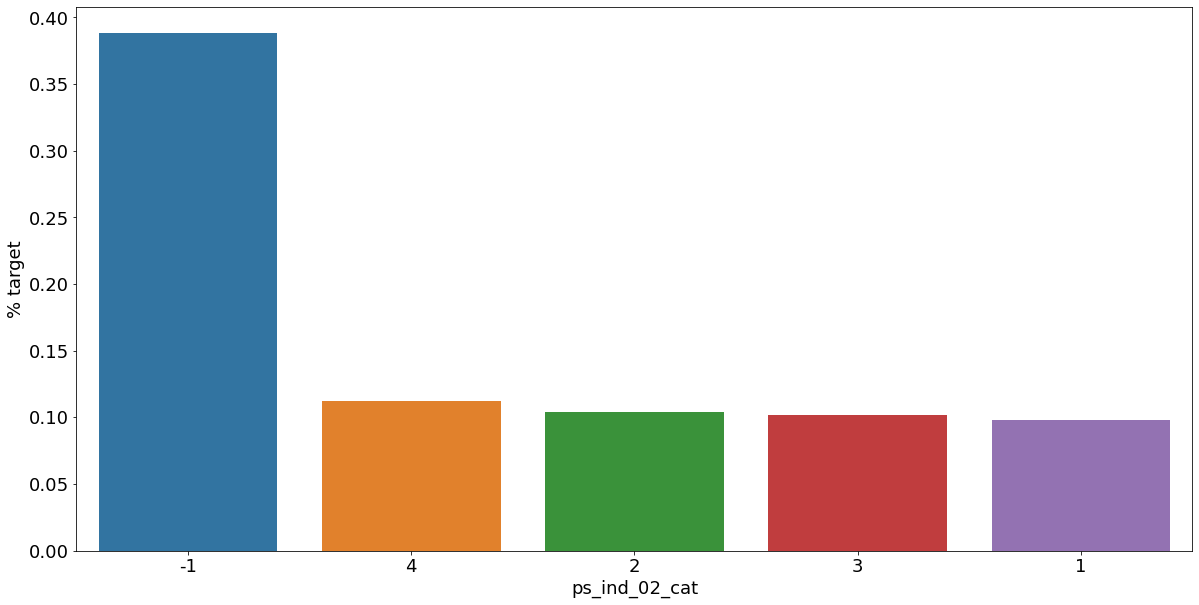

<Figure size 432x288 with 0 Axes>

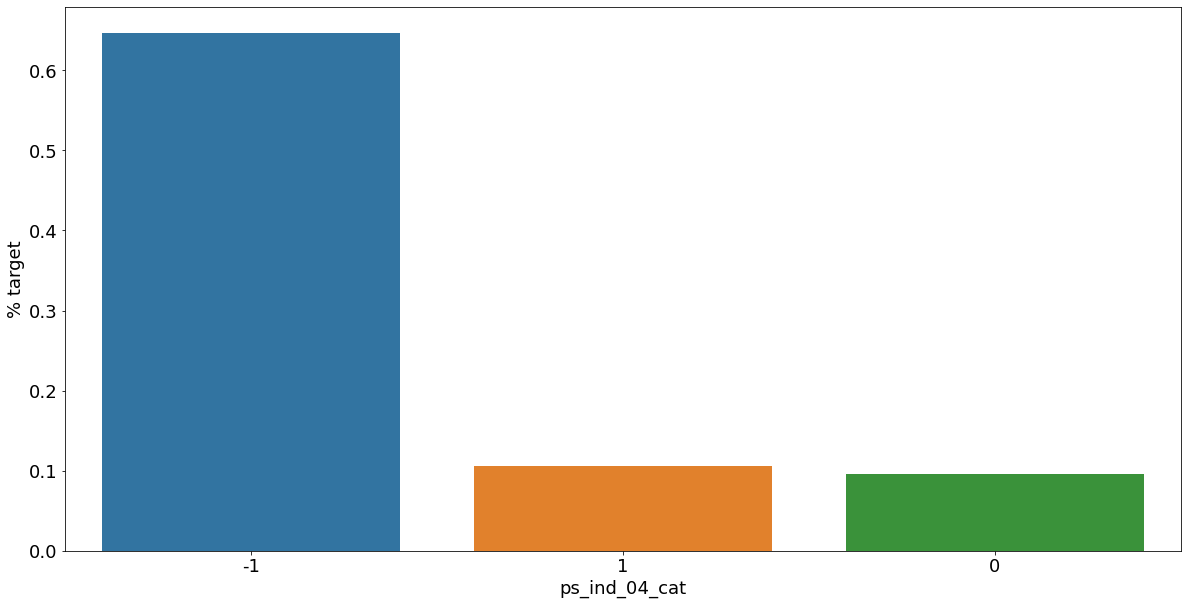

<Figure size 432x288 with 0 Axes>

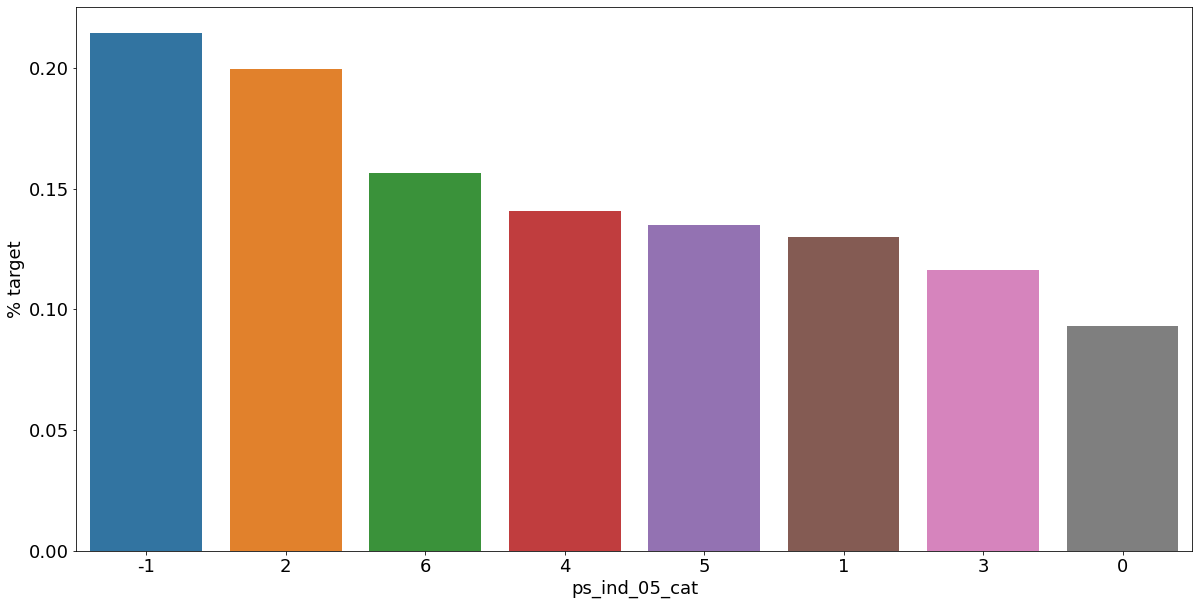

<Figure size 432x288 with 0 Axes>

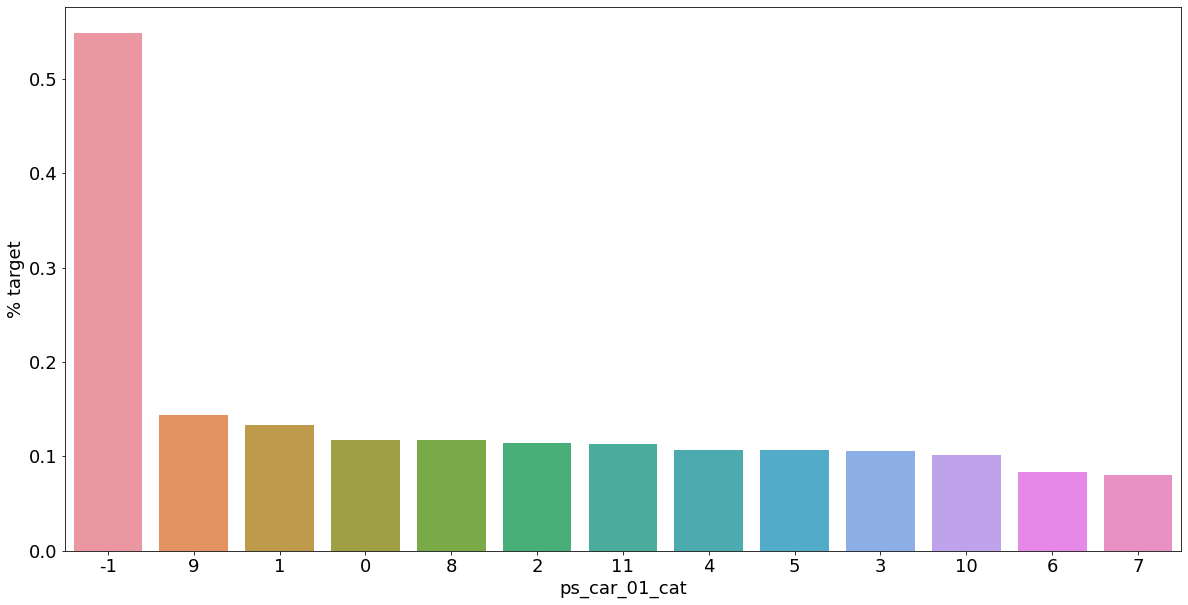

<Figure size 432x288 with 0 Axes>

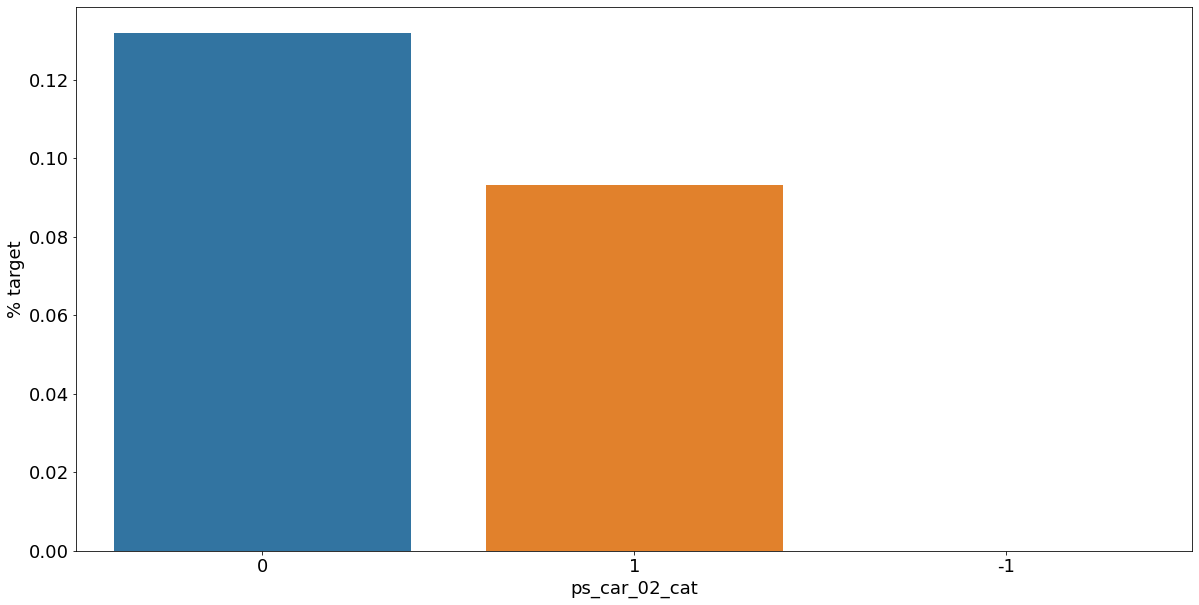

<Figure size 432x288 with 0 Axes>

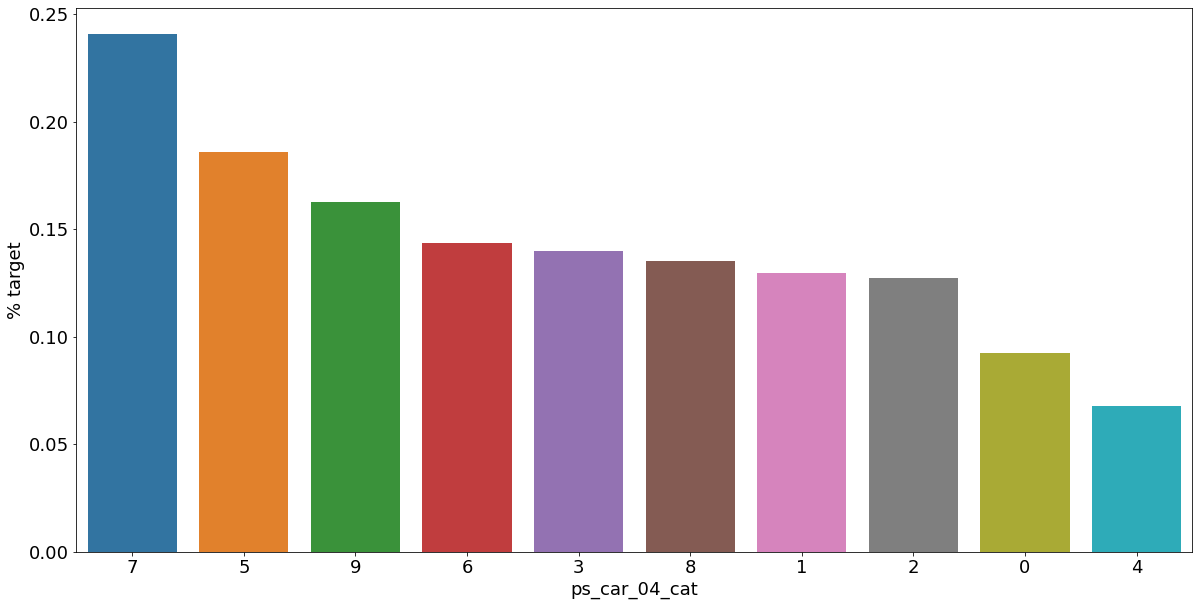

<Figure size 432x288 with 0 Axes>

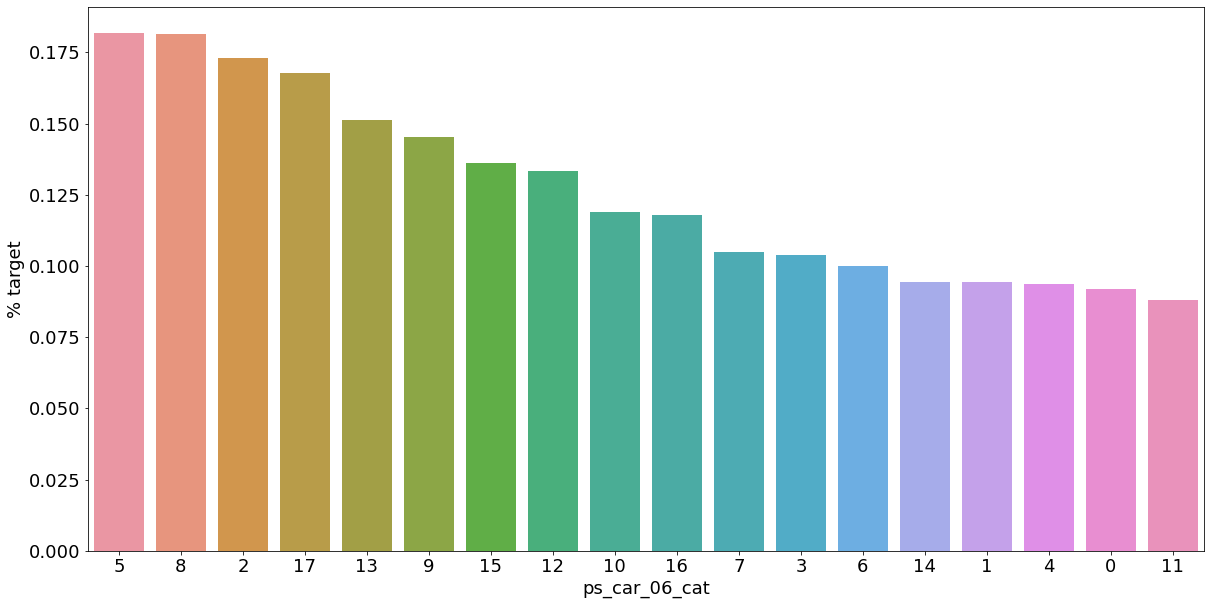

<Figure size 432x288 with 0 Axes>

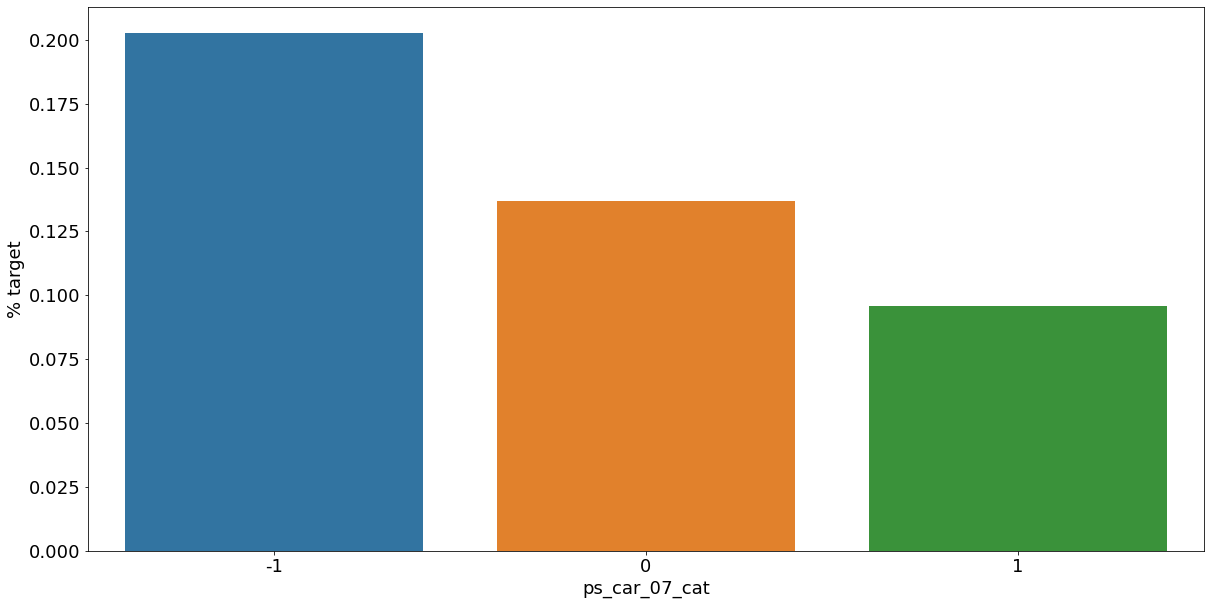

<Figure size 432x288 with 0 Axes>

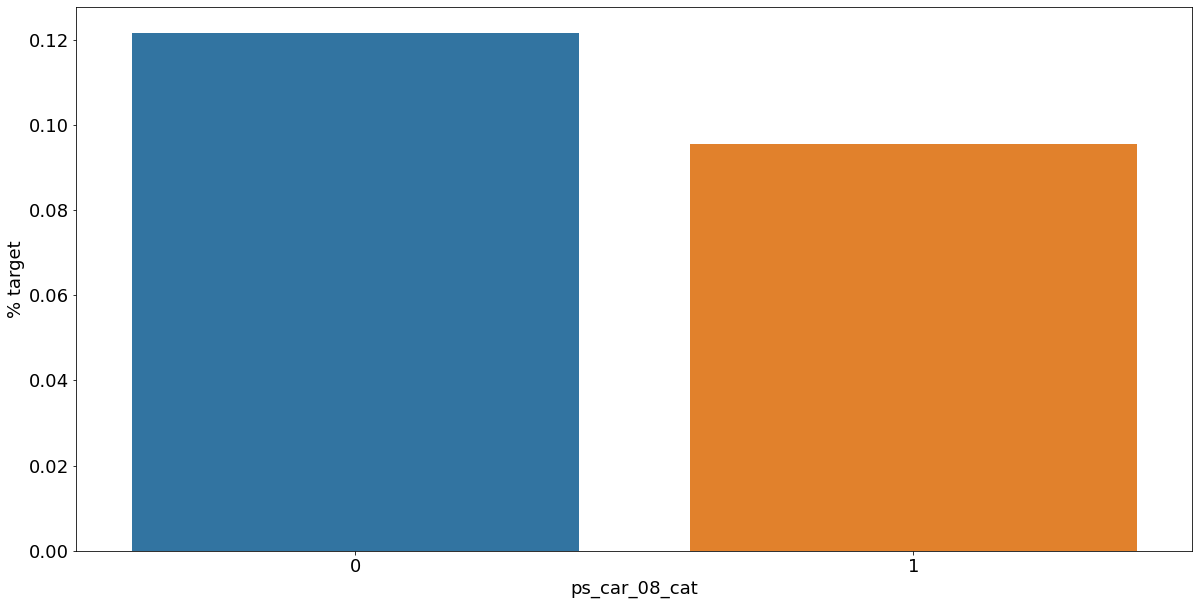

<Figure size 432x288 with 0 Axes>

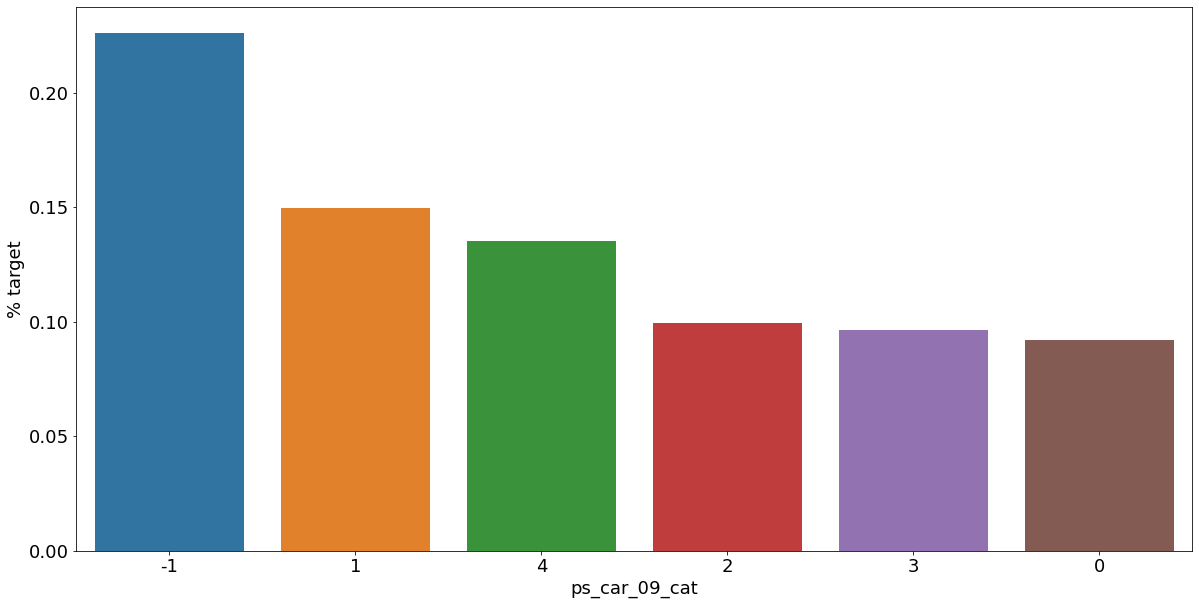

<Figure size 432x288 with 0 Axes>

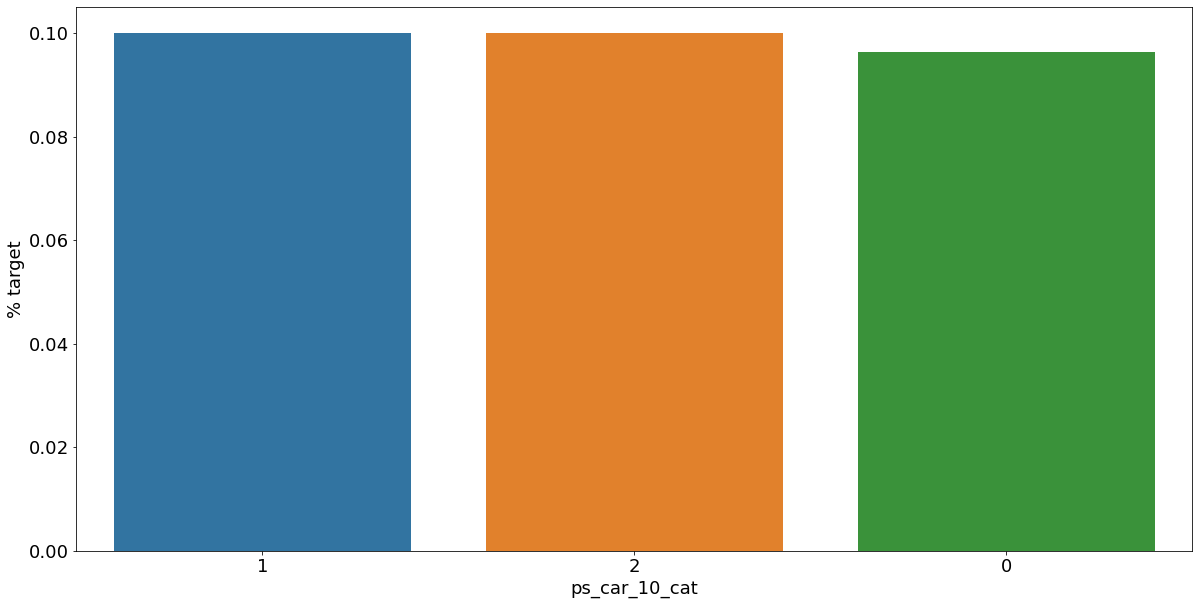

In [55]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v :
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    # 범주형 변수별 target = 1인 비율 계산
    cat_perc = train[[f, 'target']].groupby([f], as_index=False).mean()
    #print(cat_perc)
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    # 바 그래프
    # tartget 평균값 별 내림차순으로 정리
    sns.barplot(ax=ax, x=f, y='target', data = cat_perc, order=cat_perc[f])
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();

결측값이 있는 변수에서 알 수 있듯이 결측값을 예를들어 중간값으로 대체하는 대신 별도의 범주값으로 유지하는 것이 좋습니다. 결측값을 가진 고객은 보험 청구를 요청할 확률이 훨씬 높은(경우에 따라 훨씬 낮은) 것으로 보입니다.

## Interval variables

Interval variables 사이의 상관관계를 확인하는 것
hearmap은 변수들의 상관관계를 확인하기 위한 좋은 방법이다. 
아래 코드는 an example by Michael Waskom을 기반으로 만들었다.

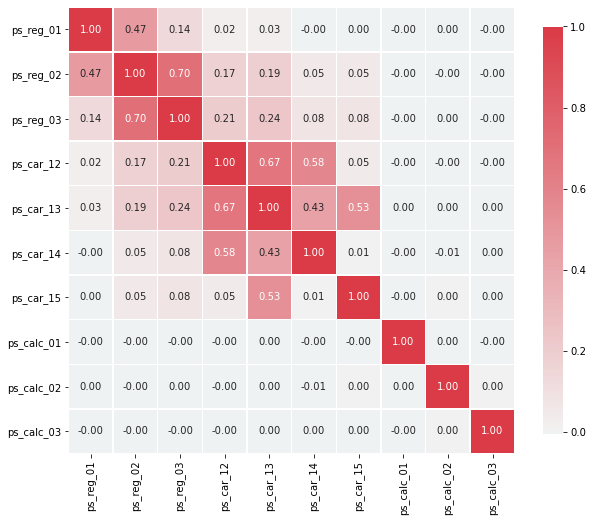

In [56]:
def corr_heatmap(v) :
    correlations = train[v].corr() # .corr()는 상관관계를 보여준는 것
    
    # 두가지 색상의 사이로 color map 만들기
    cmap = sns.diverging_palette(200, 10, as_cmap=True)
    
    fig, ax, plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center = 0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show();
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

아래 변수들은 서로 큰 상관관계에 있다. :
- ps_reg_02 and ps_reg_03 (0.7)
- ps_car_12 and ps_car13 (0.67)
- ps_car_12 and ps_car14 (0.58)
- ps_car_13 and ps_car15 (0.67)




In [1]:
print)

NameError: name 'p' is not defined